In [2]:
#### import library ####
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [3]:
#### Experimental Setup ####
p = 7 #[mTorr] Pressure
kB = 1.38e-23 #[J/K] [m2 kg K-1 s-2] Boltzmann constant
kB1 = 8.617e-5 #[eV/K] Boltzmann constant
e = 1.6e-19 #[C] electronic charge
M = 1.67e-27 #[kg] mass of H atom
m = 9.1e-31 #[kg] mass of electorn
ro = 2.75 #[cm] radius of chamber
l = 24 #[cm] chamber length
Tg = 300 #[K] room temperature
V = np.pi*ro**2*l #[cm^3] discharge volume
A = 2*np.pi*ro*l+2*np.pi*ro**2 #[cm^2] loss area
v0 = 100*(8*Tg*kB/(M*np.pi))**0.5 #[cm/s] mean velocity of H atom
ng = (p/7.5)/(Tg*kB)*1e-6 #[cm^-3]
sigma_i = 5e-15 #[cm2] #
lambda_i = 1/(ng*sigma_i) #[cm] ion-neutral mean free path
hl = 0.86*(3+l/2/lambda_i)**-0.5
hR = 0.8*(4+ro/lambda_i)**-0.5
Aeff = 2*np.pi*ro*(l*hR+ro*hl)  #[cm^2] effective area
deff = V/Aeff #[cm]
g = 0.1 #Recombination Factor
LAMBDAeff = ((2.405/ro)**2+(np.pi/l)**2)**-0.5 #[cm]
D_Kn = v0 * LAMBDAeff/3 #[cm2/s]
Deff = D_Kn
T1 = LAMBDAeff**2/Deff #[s]

In [4]:
###### Functions ######
def electron_balance_eqn(x, t, Power): 
    Te = x[0]
    nH = x[1]
    nHp = x[2]
    nH2p = x[3]
    nH3p = x[4]
    x6 = 0.5
    uB = np.sqrt(e*Te/M)*100 #[cm/s] #kB/kB1 = e
    Vs = Te*np.log(np.sqrt(M/(2*np.pi*m)))
    t0 = deff/uB #[s] Characteristic transit time of H+ ion 
    
    ##### Rate coefficient calculation #####
    # ref. R. K. Janev, et al., Elementary Processes in Hydrogen-Helium Plasmas, Springer (1987)
    # H + e -> H+ + 2e, Reaction 2.1.5 E = 13.6
    k1 = np.exp(-3.271396786375e+01+1.353655609057e+01*np.log(Te)-5.739328757388e+00*(np.log(Te))**2+1.563154982022e+00*(np.log(Te))**3-2.877056004391e-01*(np.log(Te))**4+3.482559773737e-02*(np.log(Te))**5-2.631976175590e-03*(np.log(Te))**6+1.119543953861e-04*(np.log(Te))**7-2.039149852002e-06*(np.log(Te))**8)
    # H+ + e -> H + hv, Reaction 2.1.8 E = Te
    k2 = 3.92e-14*(13.6/Te)**1.5/(13.6/Te+0.35) # n = 1s
    # H2 + e -> 2H + e, Reaction 2.2.5 E = 10
    k3 = np.exp(-2.858072836568e+01+1.038543976082e+01*np.log(Te)-5.383825026583e+00*(np.log(Te))**2+1.950636494405e+00*(np.log(Te))**3-5.393666392407e-01*(np.log(Te))**4+1.006916814453e-01*(np.log(Te))**5-1.160758573972e-02*(np.log(Te))**6+7.411623859122e-04*(np.log(Te))**7-2.001369618807e-05*(np.log(Te))**8)
    # H2 + e -> H2+ + 2e, Reaction 2.2.9 E = 15.4
    k4 = np.exp(-3.568640293666e+01+1.733468989961e+01*np.log(Te)-7.767469363538e+00*(np.log(Te))**2+2.211579405415e+00*(np.log(Te))**3-4.169840174384e-01*(np.log(Te))**4+5.088289820867e-02*(np.log(Te))**5-3.832737518325e-03*(np.log(Te))**6+1.612863120371e-04*(np.log(Te))**7-2.893391904431e-06*(np.log(Te))**8)
    # H2 + e -> H+ + H + 2e, Reaction 2.2.10 E = 18
    k5 = np.exp(-3.834597006782e+01+1.426322356722e+01*np.log(Te)-5.826468569506e+00*(np.log(Te))**2+1.727940947913e+00*(np.log(Te))**3-3.598120866343e-01*(np.log(Te))**4+4.822199350494e-02*(np.log(Te))**5-3.909402993006e-03*(np.log(Te))**6+1.738776657690e-04*(np.log(Te))**7-3.252844486351e-06*(np.log(Te))**8)
    # H2+ + e -> 2H+ + 2e, Reaction 2.2.11 E = 15.5
    k6 = np.exp(-3.746192301092e+01+1.559355031108e+01*np.log(Te)-6.693238367093e+00*(np.log(Te))**2+1.981700292134e+00*(np.log(Te))**3-4.044820889297e-01*(np.log(Te))**4+5.352391623039e-02*(np.log(Te))**5-4.317451841436e-03*(np.log(Te))**6+1.918499873454e-04*(np.log(Te))**7-3.591779705419e-06*(np.log(Te))**8)
    # H2+ + e -> H+ + H + e, Reaction 2.2.12 E = 10.5
    k7 = np.exp(-1.781416067709e+01+2.277799785711e+00*np.log(Te)-1.266868411626e+00*(np.log(Te))**2+4.296170447419e-01*(np.log(Te))**3-9.609908013189e-02*(np.log(Te))**4+1.387958040699e-02*(np.log(Te))**5-1.231349039470e-03*(np.log(Te))**6+6.042383126281e-05*(np.log(Te))**7-1.247521040900e-06*(np.log(Te))**8)
    # H2+ + e -> 2H, Reaction 2.2.14 E = Te
    k8 = np.exp(-1.670435653561e+01-6.035644995682e-01*np.log(Te)-1.942745783445e-08*(np.log(Te))**2-2.005952284492e-07*(np.log(Te))**3+2.962996104431e-08*(np.log(Te))**4+2.134293274971e-08*(np.log(Te))**5-6.353973401838e-09*(np.log(Te))**6+6.152557460831e-10*(np.log(Te))**7-2.025361858319e-11*(np.log(Te))**8)
    # H3+ + e -> H2 + H, Reaction 2.2.15 E = Te
    k9 = np.exp(-1.700270758355e+01-4.050073042947e-01*np.log(Te)+1.018733477232e-08*(np.log(Te))**2-1.695586285687e-08*(np.log(Te))**3+1.564311217508e-10*(np.log(Te))**4+1.979725412288e-09*(np.log(Te))**5-4.395545994733e-10*(np.log(Te))**6+3.584926377078e-11*(np.log(Te))**7-1.024189019465e-12*(np.log(Te))**8)
    # H3+ + e -> H+ + 2H + e, Reaction 2.2.16 E = 14
    k10 = np.exp(-3.078408636631e+01+1.509421488513e+01*np.log(Te)-7.349167207324e+00*(np.log(Te))**2+2.320966107642e+00*(np.log(Te))**3-4.818077551719e-01*(np.log(Te))**4+6.389229162737e-02*(np.log(Te))**5-5.161880953089e-03*(np.log(Te))**6+2.303985092606e-04*(np.log(Te))**7-4.344846146197e-06*(np.log(Te))**8)
    # H2+ + H2 -> H3+ + H, Reaction 4.3.3 E = 0
    k11 = 2.1e-9  #for 0.3eV Hydrogen atom
    # H(1s) + e -> H(2p) + e, Reaction 2.1.1 E = 10.2 
    k12 = np.exp(-4.991816994666e+02+6.320402753550e+02*np.log(Te)-3.652213752597e+02*(np.log(Te))**2+1.165699645892e+02*(np.log(Te))**3-2.250557133404e+01 *(np.log(Te))**4+2.695101794905e+00*(np.log(Te))**5-1.958839549072e-01*(np.log(Te))**6+7.917154881015e-03*(np.log(Te))**7-1.365267533573e-04*(np.log(Te))**8)
    # H(1s) + e -> H(2s) + e, Reaction 2.1.2 E = 10.2
    k13 = np.exp(-1.773223143614e+03+2.868021256119e+03*np.log(Te)-2.019174875577e+03*(np.log(Te))**2+7.913558639288e+02*(np.log(Te))**3-1.890880793711e+02*(np.log(Te))**4+2.824418882926e+01*(np.log(Te))**5-2.579116350676e+00*(np.log(Te))**6+1.318146425812e-01*(np.log(Te))**7-2.890652428531e-03*(np.log(Te))**8)
    # H2 + e -> H2 + e, Reaction 2,2,2 E = 12.1
    k14 = np.exp(-4.293519441750e+02+5.112210939087e+02*np.log(Te)- 2.848127939455e+02*(np.log(Te))**2+8.831033879636e+01*(np.log(Te))**3-1.665959177505e+01*(np.log(Te))**4+1.957960915869e+00*(np.log(Te))**5-1.401282416514e-01*(np.log(Te))**6+5.591134833381e-03*(np.log(Te))**7-9.537010324465e-05*(np.log(Te))**8)
    
    ##### Energy Loss per Reaction #####
    E1 = 13.6
    E2 = Te
    E3 = 10
    E4 = 15.4
    E5 = 18
    E6 = 15.5
    E7 = 10.5
    E8 = Te
    E9 = Te
    E10 = 14
    E11 = 0
    E12 = 10.2
    E13 = 10.2
    E14 = 12.1
    
    #Quasi-Neutrality eqn
    ne = nHp + nH2p + nH3p
    
    #Hydrogen atom conservation eqn
    nH2 = ng-(0.5*(nH+nHp)+nH2p+1.5*nH3p)
    
    #Particle balance eqn for electron
    dne_dt = (k1*ne*nH)+(k4*ne*nH2)+(k5*ne*nH2)+(k6*ne*nH2p)-(k2*ne*nH)-(k8*ne*nH2p)-(k9*ne*nH3p)-ne*uB*Aeff/V
    
    #Power balance eqn for electron
    dT_dt = 2/3*(Power(t)/V/ne - k1*nH*E1 + k2*nHp*E2 + k3*nH2*E3 + k4*nH2*E4 + k5*nH2*E5 + k6*nH2p*E6 + k7*nH2p*E7 + k8*nH2p*E8 + k9*nH3p*E9 + k10*nH3p*E10 + k12*nH*E12 + k13*nH*E13 + k14*nH2*E14 - (Vs+5/2*Te)*uB*Aeff)-dne_dt*Te/ne
    
    #Particle balance eqn for other species except electron
    dnH_dt = -(k1*ne*nH)+(k2*nHp*ne)+2*(k3*nH2*ne)+(k5*nH2*ne)+(k7*nH2p*ne)+2*(k8*nH2p*ne)+(k9*nH3p*ne)+2*(k10*nH3p*ne)+(k11*nH2p*nH2)-(nH/(T1/g))+(nHp/(t0/x6))+(nH3p/(np.sqrt(3)*t0/x6))
    dnHp_dt = (k1*ne*nH)-(k2*nHp*ne)+(k5*nH2p*ne)+2*(k6*nH2p*ne)+(k7*nH2p*ne)+(k10*nH3p*ne)-(nHp/(t0/x6))
    dnH2p_dt = (k4*nH2*ne)-(k6*nH2p*ne)-(k7*nH2p*ne)-(k8*nH2p*ne)-(k11*nH2p*nH2)-(nH2p/(np.sqrt(2)*t0/x6))
    dnH3p_dt = -(k9*nH3p*ne)-(k10*nH3p*ne)+(k11*nH2p*nH2)-(nH3p/(np.sqrt(3)*t0/x6))
    
    return [dT_dt, dnH_dt, dnHp_dt, dnH2p_dt, dnH3p_dt]

def Te_0(t):
    return T_inf*(1+2*3.3e4*(t-duty*period))**-2

def ne_0(t):
    return n_inf*(1+2*3.3e4*(t-duty*period))**-0.5

In [5]:
###### Power Setting ######
P = 1000*6.241509e18 #[eV/s] Input Power
duty = 0.5
period = 1000
time_resolution = 1e-1
t = np.arange(0, period, time_resolution)

def Power_rectangular(t):
    if t <= duty*period:
        return P
    else:
        return 0
    
def Power_logistic(t):
    t1 = 50  #Point where the power starts to decrease
    t2 = 150 #Point where the power becomes zero
    C = 2
    B = np.exp(-t2/C)
    A = P/(np.exp(-t1/C)-B)
    
    if t <= t1:
        return P
    elif t <= t2 and t > t1:
        return A*(np.exp(-t/C)-B)
    else:
        return 0

In [6]:
###### Electron Temperature & Density Calculation ######
x0 = [11,1e11, 1e6, 1e9, 1e9] #Te, nH, nHp, nH2p, nH3p
args = (Power_rectangular,)
ans1 = odeint(electron_balance_eqn, x0, t, args, rtol=10**-3, mxstep=10**4)
T = ans1[:,0]
H = ans1[:,1]
Hp = ans1[:,2]
H2p = ans1[:,3]
H3p = ans1[:,4]
ne = Hp + H2p + H3p
H2 = ng-(0.5*(H+Hp)+H2p+1.5*H3p)

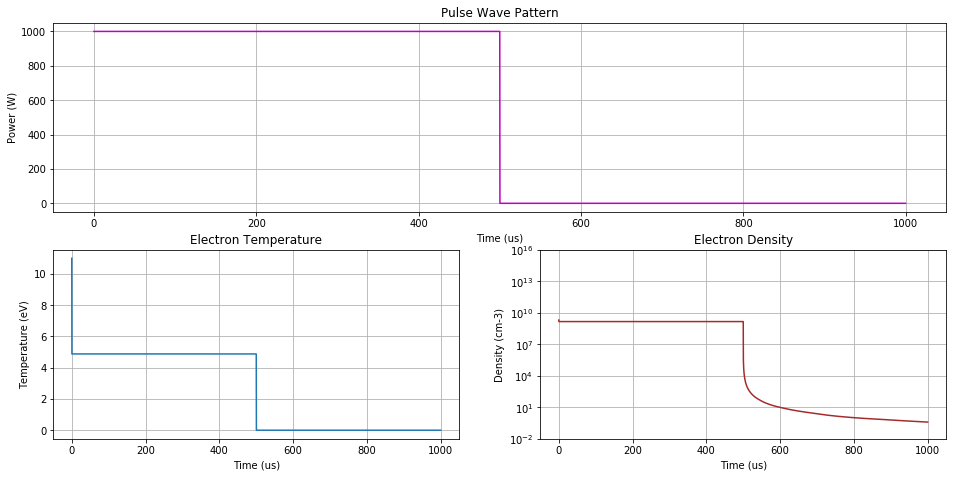

In [7]:
plt.figure(figsize=(16,16))
Power_list = []
for i in t:
    Power_list.append(Power_rectangular(i)/6.241509e18)
plt.subplot(411)
plt.plot(t,Power_list,'m')
plt.title('Pulse Wave Pattern')
plt.xlabel('Time (us)')
plt.ylabel('Power (W)')
plt.grid(True)

plt.subplot(423)
plt.plot(t,T)
plt.xlabel('Time (us)')
plt.ylabel('Temperature (eV)')
plt.title('Electron Temperature')
plt.grid(True)

plt.subplot(424)
plt.plot(t,ne,'brown')
plt.yscale('log')
plt.xlabel('Time (us)')
plt.ylabel('Density (cm-3)')
plt.ylim(1e-2,1e16)
plt.title('Electron Density')
plt.grid(True)
plt.show()

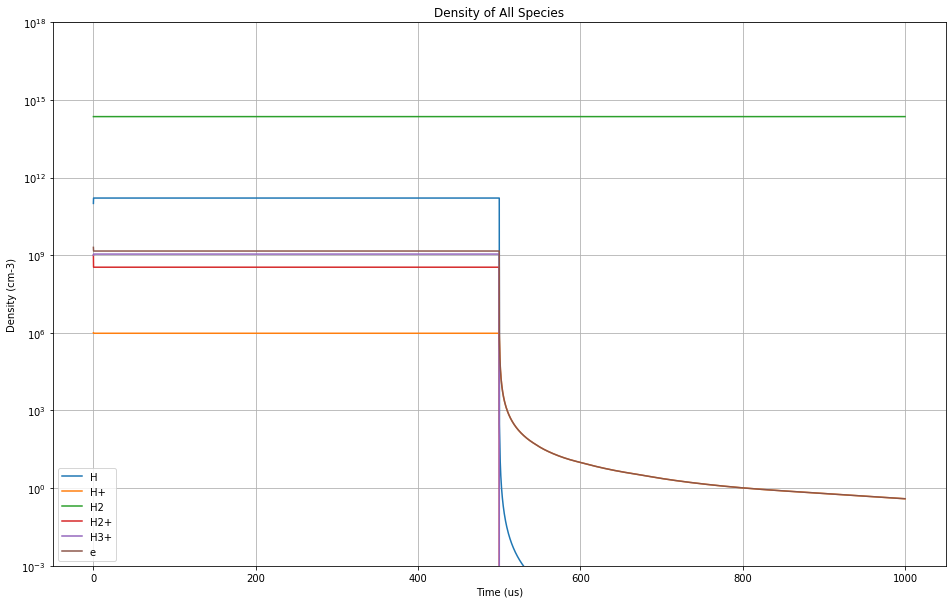

In [8]:
plt.figure(figsize=(16,10))
plt.plot(t,H,t,Hp,t,H2,t,H2p,t,H3p,t,ne)
plt.yscale('log')
plt.xlabel('Time (us)')
plt.ylabel('Density (cm-3)')
plt.ylim(1e-3,1e18)
plt.legend(['H','H+','H2','H2+','H3+','e'])
plt.title('Density of All Species')
plt.grid(True)
plt.show()

In [479]:
data = np.array([t,H,Hp,H2,H2p,H3p,ne]).T
data = pd.DataFrame(data)
data.columns= ['t','H','H+','H2','H2+','H3+','e']
data.to_csv('result.csv')